### Writeup

1. Describe what you have built and what you have found.
  - I've built a linear regression model predicting product sale standardized (0-mean, unit variance). This encoding assumes we care about each product equally regardless of product volume (obviously untrue), in reality we would likely want to slightly bias our model to higher-volume product but not as significantly as using the raw sales volumes I would wager.
2. Quantify the accuracy of the model, and any intricacies. Make sure to describe training vs validation performance and how you measure generalization performance.
   - The models are measure with two metrics: mean-squared error and within-10% accuracy. Depending on how costs grow with the size of an error and whether this model is used for other purposes (inventory management, for ex.), one or both might be relevant. The two metrics picked represent two ends of a scale: MSE saying "I want to minimize the really bad errors" and within-10% accuracy saying "I want to be optimize for the general case, occassional, but very bad, errors are okay". Other metrics (like mean absolute deviation) would be in the middle. 
   - A table at the bottom of the notebook displays the results
3. Don’t spend too much time on this. Please describe statistical exploration or modeling approaches you would have build if you had more time.
   - The answer to this prompt is in the "Immediate things to investigate before putting model into production" section

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
sales = pd.read_csv("/workingdir/data/daily_product_sales.csv", index_col="Unnamed: 0")
promotions = pd.read_csv("/workingdir/data/product_promotions.csv")
oos = pd.read_csv("/workingdir/data/daily_product_oos.csv", index_col="Unnamed: 0")

### Basic data investigation

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


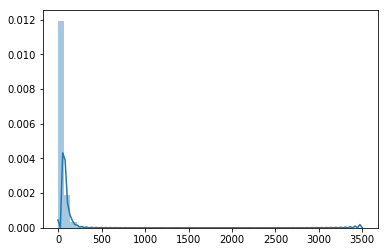

In [3]:
import numpy as np
vals = sales.values.reshape((-1,))
vals = vals[~np.isnan(vals)]
_ = sns.distplot(vals)
# very long tail on daily sale volumes (as expected)

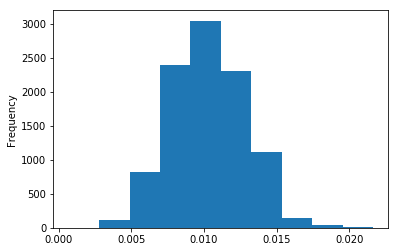

In [4]:
_ = sales.isna().mean(axis=1).plot.hist()
# Small portion of values missing

In [5]:
oos.isna().mean(axis=1).mean()
# Interesting that this dataset is missing nothing by comparison. 

0.0

Ideally, we would want to check if any missing values in `sales` happen when a product is out of stock (since we can assume those are 0). For simplicity's sake, we'll instead just assume that doesn't happen and use interpolation to impute the missing values (and backfill for the first date) 

In [6]:
sales = sales.interpolate(method="linear", axis=1)
sales.isna().mean()[sales.isna().mean() != 0.0]

2012-03-01    0.0129
dtype: float64

In [7]:
sales = sales.fillna(method="backfill")

### Standardizing the data

We can't assume the time series are "drawn from the same sample" as-is given that different products are likely to ship at very different volumes. 

That being said, if we standardize each product, we could view our task as "predict the ratio deviation in sales volume compared to typical" instead of "predict the sales volume". 
 - There is a negative here: our model will treat all products equally regardless of volume, obviously in reality we may or may not want this

For the prediction task, getting to sales volume from this "ratio deviation" metric would be trivial (multiply by the mean/variance for the product combination). 

In [8]:
product_means = sales.mean(axis=1)
product_std = sales.var(axis=1)**(1 / 2)
sales = (sales - product_means.repeat(sales.shape[1]).values.reshape(sales.shape)
 ) / product_std.repeat(sales.shape[1]).values.reshape(sales.shape)

Quick note: Why product standardization and not use brand+product to standardize?
 - doesn't make a real difference when one is standardizing with mean/variance
 - ideally, we would want this step to (a) make the time series stationary and (b) eliminate heteroskedasticity, and when doing this a more complex/data-intensive brand-level standardization approach would have benefit and could supplement a less data-intensive standardization product-by-product

### Exploring sales

Are overall sales changing over time?

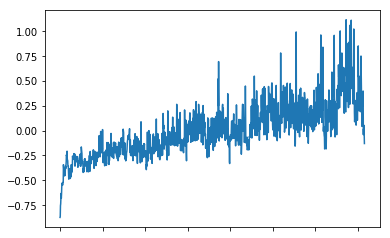

In [9]:
from matplotlib import pyplot as plt
_ = sales.mean().plot()
plt.show()

To what extend are overall sales autocorrelated?

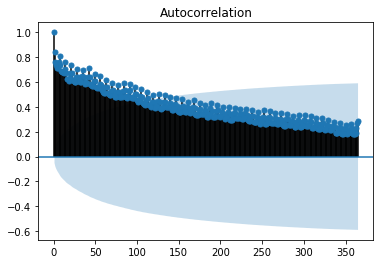

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
g = plot_acf(sales.mean(), lags=365)
# The change in rates of decline in the autocorrelation values
# signals seasonal/cyclical trends (especially early on), but
# from this plot it doesn't seem like it would be a strong effect
# compared to the autocorrelation itself

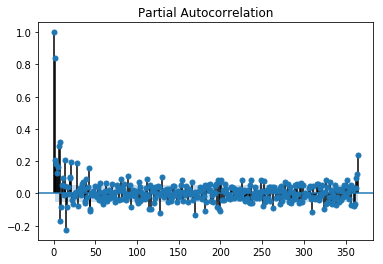

In [11]:
g = plot_pacf(sales.mean(), lags=365)
# This graph signals stronger cyclical effects (especially early on)
# than the autocorrelative plot above

### Creating training vs validation set and feature extraction

We use a rolling windows approach to construct the training dataset and the first 80% of windows gathered from each sequence is used for training with the last 20% used for testing. This approach to is chosen because:
 - The rolling windows let us use traditional, well-investigated, and well-supported (in open-source) supervised methods
 - I'm assuming a static model is used in production (one that would always be missing recent developments/relationships because it wasn't trained on recent data), so it's fair to test the model on the last 10% of the data when it wasn't trained on the 10% prior either. 
 - The model is able to see the behavior of each product 

As a very basic way of integrating the product promotion information, I'm going to assume all promotions ran for 2-days. That seems like a safe assumption (albeit I don't have the domain expertise to really say) and if we don't find a boost, then there is likely a problem somewhere.

In [12]:
from datetime import datetime
first_date = datetime.strptime(sales.columns[0], "%Y-%m-%d")
promotions["date_int"] = [(datetime.strptime(v, "%Y-%m-%d") - first_date).days for v in promotions.start_date.tolist()]

In [13]:
import statsmodels.api as sm
import calendar

assumed_promotion_length = 2
promotions = promotions

window_size = 15
dfs = []
for i in range(window_size, len(sales.columns)):
    cols_for_iteration = sales.columns[(i - window_size):i]
    df = sales[cols_for_iteration].copy()
    cur_promotions = promotions.loc[(assumed_promotion_length+1 > (
        i - promotions.date_int)) & ((i - promotions.date_int) >= 0)]
    df.columns = ["lag_{}".format(i) for i in range(window_size, 0, -1)]
    df.reset_index(inplace=True)
    df = pd.merge(
        df, cur_promotions, left_on="index", right_on="product",
        how="left").drop(columns=["start_date", "date_int"])
    df["oos"] = oos.iloc[:, i]
    df.drop_duplicates(inplace=True, subset=["index"], keep="last")
    pred_date = datetime.strptime(sales.columns[i], "%Y-%m-%d")
    df["year"] = pred_date.year - 2012
    df["month"] = str(pred_date.month)
    df["day"] = pred_date.day
    df["weekday"] = calendar.day_name[pred_date.weekday()]
    df["y"] = sales.iloc[:,i]
    dfs.append(df)

num_days_to_use = 15
sale_wide = pd.melt(sales, value_name="ratio", var_name="date")
sale_wide["dateOfYear"] = sale_wide["date"].str[-5:]
highVolumeDateFeatures = sale_wide.groupby(
    "dateOfYear", as_index=False).mean().sort_values(
        by="ratio", ascending=False).head(num_days_to_use).dateOfYear.tolist()
del sale_wide

dataset = pd.concat(dfs)
dataset = dataset.fillna(0).drop(columns="index")
del dfs
dataset.reset_index(inplace=True, drop=True)

In [14]:
dataset["highVolumeDates"] = (
    dataset["month"].apply(str).str.pad(2, fillchar="0") + "-" +
    dataset["day"].apply(str).str.pad(2, fillchar="0")
).apply(lambda x: x if x in highVolumeDateFeatures else "baseline")
dataset = sm.add_constant(pd.get_dummies(dataset, drop_first=True))

train_prop = 0.8
first_valid_row = int(
    sales.shape[0] * round(train_prop * (sales.shape[1] - window_size)))

train_dataset = dataset.iloc[:first_valid_row]
valid_dataset = dataset.iloc[first_valid_row:]
del dataset, sales, oos, promotions

In [15]:
const = ["const"]
lags = ["lag_{}".format(i) for i in range(1, window_size + 1)]
highVolumeDates = [c for c in train_dataset.columns if "highVolumeDates" in c]
day_of_week = [
    "weekday_Monday", "weekday_Saturday", "weekday_Sunday", "weekday_Thursday",
    "weekday_Tuesday", "weekday_Wednesday"
]
month_of_year = ["month_{}".format(i) for i in range(2, 13)]
promotion_features = ["f" + str(i) for i in range(0, 30)]

feat_groups = {
    "firstLag": ["const", "lag_1"],
    "Lags":
   const + lags,
    "Lags,dayOfWeek":
    const + lags + day_of_week,
    "Lags,dayOfWeek,month":
    const + lags + day_of_week + month_of_year,
    "Lags,dayOfWeek,month,highVolumeDates":
    const + lags + day_of_week + month_of_year + highVolumeDates,
    "Lags,dayOfWeek,month,highVolumeDates,oos":
    const + lags + day_of_week + month_of_year + highVolumeDates + ["oos"],
    "all":
    const + lags + day_of_week + month_of_year + highVolumeDates + ["oos"] +
    promotion_features,
}

Note on the features I have extracted:
 - `month` for month of year 
 - `weekday` for day of week
 - `const` intercept term
 - `highVolumeDays` records "baseline" (for most days) or a "month-day" stamp for particular high-volume days discovered in the training data
 - `oos` I'm assuming we know the day before whether or not the product will be in stock

Note on the features I ignored:
 - General trend (each day from the first day of the dataset counting forward to the last day) feature excluded because it significantly hurt performance (\delta 3% on "within10%" accuracy metric)
 - Product # (as a categorical variable) is excluded because hypothetically the standardization we undertook above should have eliminated product-specific general trends. One might want to introduce features representing interactions between high-volume products and existing features as there's likely pecularities which are learnable assuming high product volume

### Creating a model

For the demonstration task here, I'll stick to linear regression. 

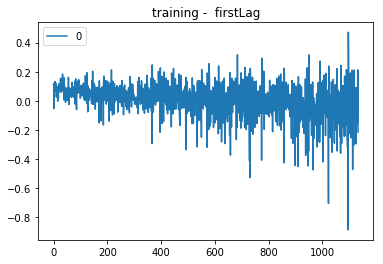

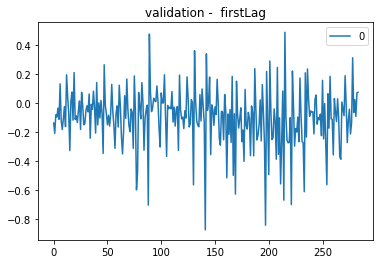

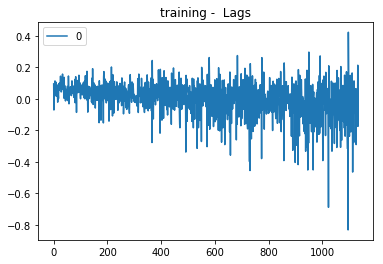

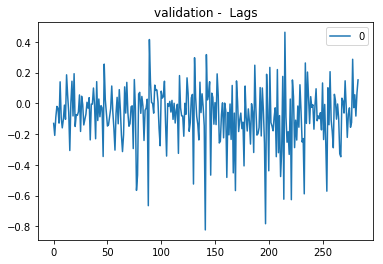

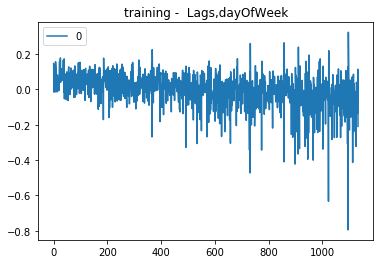

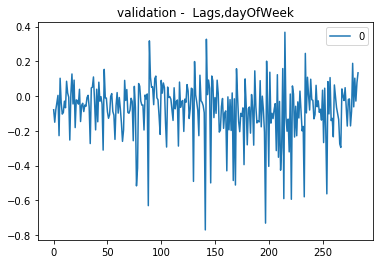

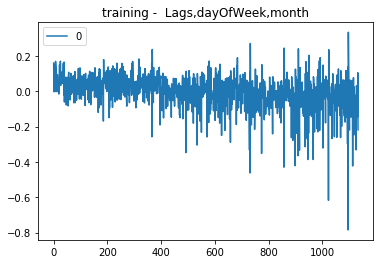

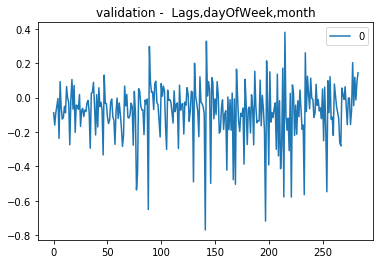

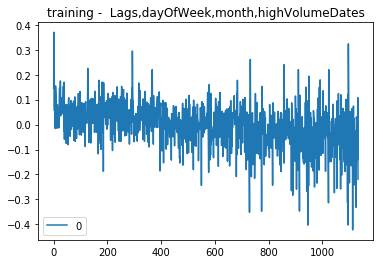

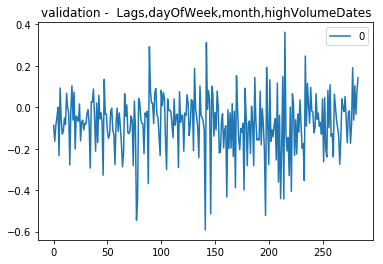

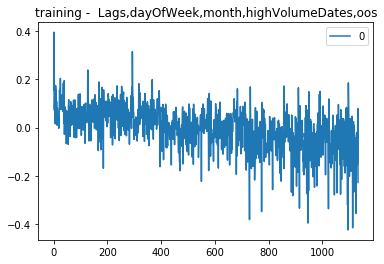

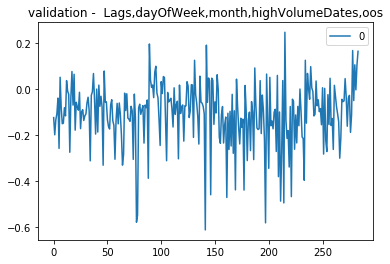

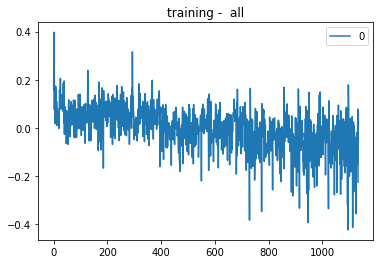

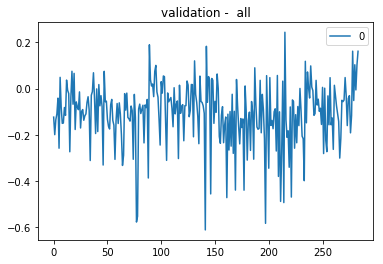

In [16]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

table = []
best_model = None
for descrip, feats in feat_groups.items():
    model = sm.OLS(train_dataset.y, train_dataset[feats])
    result = model.fit()
    scores = {"feats": descrip}
    for name, d in [("training - ", train_dataset), ("validation - ", valid_dataset)]:
        yhat = result.predict(d[feats])
        resid = np.mean((yhat - d.y).values.reshape((-1, 10000)), axis=1)
        _ = pd.DataFrame(resid).plot(title=name + " " + descrip)
        plt.show()
        scores["".join([name, "mse"])] = mean_squared_error(yhat, d.y)
        scores["".join([name, "within10%"])] = (np.abs(yhat - d.y) < 0.1).mean()
    scores["result"] = str(result.summary())
    if best_model is None or best_model.rsquared < result.rsquared:
        best_model = result
    table.append(scores)
    del result

In [17]:
pd.DataFrame(table)

,feats,result,training - mse,training - within10%,validation - mse,validation - within10%
0,firstLag,OLS Regression Res...,0.394496,0.176159,0.789774,0.136051
1,Lags,OLS Regression Res...,0.381951,0.191469,0.758851,0.154713
2,"Lags,dayOfWeek",OLS Regression Res...,0.379183,0.204972,0.750839,0.166726
3,"Lags,dayOfWeek,month",OLS Regression Res...,0.378979,0.205220,0.750702,0.167277
4,"Lags,dayOfWeek,month,highVolumeDates",OLS Regression Res...,0.376986,0.206736,0.744188,0.169514
5,"Lags,dayOfWeek,month,highVolumeDates,oos",OLS Regression Res...,0.309187,0.205633,0.616214,0.183979
6,all,OLS Regression Res...,0.305326,0.204394,0.608637,0.182394


Interestingly enough, the promotions help MSE and hurt within10% accuracy. I'm also surprised the impact isn't greater (similar to OOS). Maybe a limitation of regression? Maybe a bug in the feature engineering?

### Analyzing the best model

In [18]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                 2.598e+05
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        05:10:48   Log-Likelihood:            -9.3640e+06
No. Observations:            11340000   AIC:                         1.873e+07
Df Residuals:                11339921   BIC:                         1.873e+07
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.5013      0.003    156.026      0.000       0.495       0.508
lag_1                        0.5360      0.000   1763.196      0.000       0.535       0.537
lag_2                        0.0599      0.000    167.334      0.000       0.059       0.061
lag_3                        0.0095      0.000     26.513      0.000       0.009       0.010
lag_4                       -0.0104      0.000    -29.033      0.000      -0.011      -0.010
lag_5                       -0.0919      0.000   -254.492      0.000      -0.093      -0.091
lag_6                        0.1202      0.000    331.481      0.000       0.119       0.121
lag_7                        0.0523      0.000    143.097      0.000       0.052       0.053
lag_8                       -0.0256      0.000    -70.041      0.000      -0.026      -0.025
lag_9                        0.0040      0.000     10.984      0.000       0.003       0.005
lag_10                      -0.0143      0.000    -39.284      0.000      -0.015      -0.014
lag_11                       0.0301      0.000     83.545      0.000       0.029       0.031
lag_12                       0.0089      0.000     24.792      0.000       0.008       0.010
lag_13                      -0.0115      0.000    -31.710      0.000      -0.012      -0.011
lag_14                       0.0379      0.000    105.072      0.000       0.037       0.039
lag_15                      -0.0135      0.000    -46.401      0.000      -0.014      -0.013
weekday_Monday              -0.0435      0.001    -69.413      0.000      -0.045      -0.042
weekday_Saturday             0.0122      0.001     19.623      0.000       0.011       0.013
weekday_Sunday              -0.0226      0.001    -36.063      0.000      -0.024      -0.021
weekday_Thursday            -0.0844      0.001   -136.123      0.000      -0.086      -0.083
weekday_Tuesday              0.0140      0.001     22.355      0.000       0.013       0.015
weekday_Wednesday           -0.1288      0.001   -206.150      0.000      -0.130      -0.128
month_2                      0.0106      0.001     12.516      0.000       0.009       0.012
month_3                     -0.0075      0.001     -9.304      0.000      -0.009      -0.006
month_4                     -0.0191      0.001    -24.254      0.000      -0.021      -0.018
month_5                     -0.0346      0.001    -41.954      0.000      -0.036      -0.033
month_6                     -0.0374      0.001    -44.938      0.000      -0.039      -0.036
month_7                     -0.0430      0.001    -51.622      0.000      -0.045      -0.041
month_8                     -0.0163      0.001    -19.693      0.000      -0.018      -0.015
month_9                     -0.0217      0.001    -25.634      0.000      -0.023      -0.020
month_10      

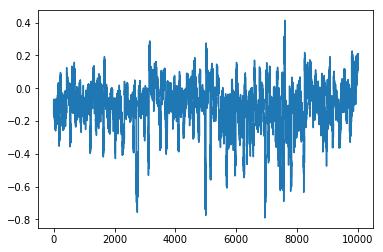

In [19]:
_ = pd.Series((best_model.predict(valid_dataset[feat_groups["all"]]) -
           valid_dataset["y"]).values.reshape((10000,
                                               -1)).mean(axis=1)).plot()

Maybe products should have been clustered and included as features (or included as features directly, but that's 9999 extra features), average residual by product seems to vary widely

### Immediate things to investigate before putting model into production
 - Should we standardize brand/products by metrics more robust than mean/variance? Maybe a standardization that preserves the importance of high-volume products over low-volume products?
 - Ways to reduce heteroskedasticity in the training data (doesn't seem as bad in the validation data, surprisingly enough)
 - More powerful model (random forest, SVMs, RNNs maybe) that would be able to better capture interactions between features? 
 - More features? Obvious first choices are expanding the lag window and using more "highVolumeDates" features, but coming up with new types of features would also help
  - High volume days of the year are useful features, are low-volume days?
  - Using general website traffic information
  - Timestamps on days AFTER high-volume days (where lag-1 will be near-useless and need to be counteracted, note that a more powerful model could solve this issue as well)
  - Should we have more than 15 lag variables? More than 15 high-volume days?
 - With more powerful models and more features, comes more potent risks of overfitting. We'd also need to investigate regularization approaches and perform feature selection.
 - Treat "maximum product promotion runtime" as a hyperparameter and pick via validation result
 - Using brand data